**Результаты so far:**

*   Баланс классов в train/valid почти не отличается (разница меньше 1%)
*   SOTA Accuracy на лидерборде = 0.99 (mBART)
*   Воспроизведен бейзлай RSG (Accuracy 0.66 на валидации)
*   Тюнинг параметров Tf-idf (Accuracy 0.63 на валидации) 


**TODOS**
*  Эвристики
*  Ошибки в разметке


# Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/RUSSE" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""
        return pd.read_json(path_or_buf=self.path, lines=True)

In [3]:
train = JSONL_handler('data/RUSSE/train.jsonl')
train = train.to_pandas()

valid = JSONL_handler('data/RUSSE/val.jsonl')
valid = valid.to_pandas()

In [4]:
train.head(3)

,idx,word,sentence1,sentence2,start1,end1,start2,end2,label,gold_sense1,gold_sense2
0,0,двор,В нашей деревне осталось от силы двадцать дворов,"Солнце стояло уже высоко, когда справа от дороги я увидел деревеньку дворов в пятнадцать",42,49,69,76,True,1,1
1,1,доклад,Табличка на дверях: «Без доклада не входить»,"Вчера отбыл в столицу первый секретарь обкома […], вызванный то ли «на ковёр», то ли на сезонный доклад об урожае",25,33,97,104,False,4,2
2,2,засада,"У нас вообще […] засада с героями, способными дотягивать в жизни до собственного творчества",Там в воскресенье все магазины закрыты – вот ведь засада!,17,24,50,57,True,2,2


# Data Exploration

In [5]:
import matplotlib.pyplot as plt

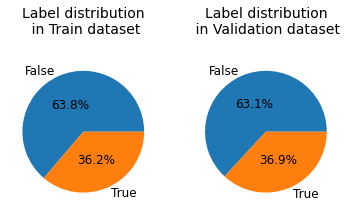

In [6]:
# Train/Valid Label Distribution 

plt.subplot(1,2,1)
plt.title('Label distribution\n in Train dataset\n', fontsize=14)
plt.pie(train['label'].value_counts(), 
        autopct="%.1f%%", 
        labels=train['label'].value_counts().keys(), pctdistance=0.5, 
        textprops = dict(fontsize = 12))

plt.subplot(1,2,2)
plt.title('Label distribution\n in Validation dataset\n', fontsize=14)
plt.pie(valid['label'].value_counts(), 
        autopct="%.1f%%", 
        labels=valid['label'].value_counts().keys(), pctdistance=0.5, 
        textprops = dict(fontsize = 12))
plt.show()

In [7]:
print(f"Train datasen contains {len(train)} samples.")
print(f"Valid dataset contains {len(valid)} samples.")

Train datasen contains 19845 samples.
Valid dataset contains 8505 samples.


In [8]:
train.word.value_counts()[:10]

дело        717
дух         665
единица     563
защита      505
знак        441
диск        439
действие    382
закон       365
задержка    353
день        333
Name: word, dtype: int64

In [9]:
train.word.value_counts(normalize=True)[:10]

дело        0.036130
дух         0.033510
единица     0.028370
защита      0.025447
знак        0.022222
диск        0.022121
действие    0.019249
закон       0.018393
задержка    0.017788
день        0.016780
Name: word, dtype: float64

# Base Models

## RSG Baseline

In [10]:
%%capture
%%bash
wget -q --show-progress "https://russiansuperglue.com/tasks/tf_idf" -O temp.zip
unzip temp.zip -d data

In [11]:
import joblib
import codecs
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [12]:
vect = joblib.load("data/tfidf.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
# taken from https://github.com/RussianNLP/RussianSuperGLUE/blob/master/tfidf_baseline/RUSSE.py
import codecs
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def build_feature_RUSSE(row):
    sentence1 = row["sentence1"].strip()
    sentence2 = row["sentence2"].strip()
    word = row["word"].strip()
    label = row.get("label")
    res = f"{sentence1} {sentence2} {word}"
    return res, label


def build_features_RUSSE(path, vect):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(build_feature_RUSSE, lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    ids = [x["idx"] for x in lines]
    return (vect.transform(texts), labels), ids


def fit_RUSSE(train, labels):
    clf = LogisticRegression()
    return clf.fit(train, labels)


def eval_RUSSE(train_path, val_path, test_path, vect):
    train, _ = build_features_RUSSE(train_path, vect)
    val, _ = build_features_RUSSE(val_path, vect)
    test, ids = build_features_RUSSE(test_path, vect)
    clf = fit_RUSSE(*train)
    try:
        test_score = clf.score(*test)
    except ValueError:
        test_score = None
    val_pred = clf.predict(val[0])
    print(classification_report(val[1], val_pred))
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
        "test": test_score,
    }


train_path = "data/RUSSE/train.jsonl"
val_path = "data/RUSSE/val.jsonl"
test_path = "data/RUSSE/test.jsonl"

_, RUSSE_scores = eval_RUSSE(train_path, val_path, test_path, vect)
train_scr = RUSSE_scores['train']
valid_scr = RUSSE_scores['val']


print(f"Accuracy Score on Train: {train_scr}") # should be around 0.71

print(f"Accuracy Score on Valid: {valid_scr}") # should be around 0.66

              precision    recall  f1-score   support

       False       0.68      0.90      0.77      5366
        True       0.61      0.26      0.36      3139

    accuracy                           0.67      8505
   macro avg       0.64      0.58      0.57      8505
weighted avg       0.65      0.67      0.62      8505

Accuracy Score on Train: 0.7103552532123961
Accuracy Score on Valid: 0.6654908877131099


## Modified

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [15]:
# concatenate columns 

def build_feature_RUSSE(row):
    sentence1 = row["sentence1"].strip()
    sentence2 = row["sentence2"].strip()
    word = row["word"].strip()
    res = f"{sentence1} {sentence2} {word}"
    return res

train_concat = []
for i, row in train.iterrows():
    train_concat.append(build_feature_RUSSE(row))
train['concatenated'] = train_concat

valid_concat = []
for i, row in valid.iterrows():
    valid_concat.append(build_feature_RUSSE(row))
valid['concatenated'] =  valid_concat

In [16]:
train.head(2)

,idx,word,sentence1,sentence2,start1,end1,start2,end2,label,gold_sense1,gold_sense2,concatenated
0,0,двор,В нашей деревне осталось от силы двадцать дворов,"Солнце стояло уже высоко, когда справа от дороги я увидел деревеньку дворов в пятнадцать",42,49,69,76,True,1,1,"В нашей деревне осталось от силы двадцать дворов Солнце стояло уже высоко, когда справа от дороги я увидел деревеньку дворов в пятнадцать двор"
1,1,доклад,Табличка на дверях: «Без доклада не входить»,"Вчера отбыл в столицу первый секретарь обкома […], вызванный то ли «на ковёр», то ли на сезонный доклад об урожае",25,33,97,104,False,4,2,"Табличка на дверях: «Без доклада не входить» Вчера отбыл в столицу первый секретарь обкома […], вызванный то ли «на ковёр», то ли на сезонный доклад об урожае доклад"


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

steps = [('tfidf', TfidfVectorizer()),
         ('logreg', LogisticRegression(class_weight='balanced'))]

parameters = {'logreg__C': np.arange(0.01, 1.9),
              'tfidf__min_df': np.arange(0.001, 0.1, 0.03),
              'tfidf__max_df': np.arange(0.6 , 1.0, 0.1),
              'tfidf__ngram_range': [(1,2), (1,3)],
              'tfidf__analyzer': ['char_wb', 'word']
              }

X_train = train.concatenated
X_test = valid.concatenated

y_train = train.label
y_test = valid.label

pipeline = Pipeline(steps)

search = GridSearchCV(pipeline, cv=3, param_grid = parameters)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Accuracy: {}".format(search.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(search.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.6398589065255732
              precision    recall  f1-score   support

       False       0.74      0.66      0.70      5366
        True       0.51      0.61      0.56      3139

    accuracy                           0.64      8505
   macro avg       0.63      0.63      0.63      8505
weighted avg       0.66      0.64      0.64      8505

Tuned Model Parameters: {'logreg__C': 1.01, 'tfidf__analyzer': 'word', 'tfidf__max_df': 0.6, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2)}


# Heruistics

In [78]:
from base import BaseSolver

class RusseSolver(BaseSolver):
   
    def __init__(self, path: str, path_valid=None):
        super(RusseSolver, self).__init__(path, path_valid)

    def heruistic_same_form(self, final_desicion=None):
        y_true = self.valid.label
        y_pred = []

        c = 0
        c_true = 0
        for i, row in self.valid.iterrows():
            word1 = row.sentence1[row.start1:row.end1].lower()
            word2 = row.sentence2[row.start2:row.end2].lower()
            if word1 == word2:
                c += 1
                if row.label is False:
                    c_true += 1
                y_pred.append(False)
            else:
                y_pred.append(final_desicion(test_size=1)[0])
        print(f'Heruistic happend for {c} samples, {c_true} of them correct')
        self.show_report(y_true, y_pred)

## Same form (Not so good)

In [79]:
# Совпадение словоформы (same_form) + Majority Vote

solver = RusseSolver(path='data/RUSSE/train.jsonl',
                     path_valid='data/RUSSE/val.jsonl')
solver.heruistic_same_form(final_desicion=solver.majority_class)

Heruistic happend for 1265 samples, 747 of them correct
              precision    recall  f1-score   support

       False       0.63      1.00      0.77      5366
        True       0.00      0.00      0.00      3139

    accuracy                           0.63      8505
   macro avg       0.32      0.50      0.39      8505
weighted avg       0.40      0.63      0.49      8505



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# Совпадение словоформы (same_form) + Random Choice

solver = RusseSolver(path='data/RUSSE/train.jsonl',
                     path_valid='data/RUSSE/val.jsonl')
solver.heruistic_same_form(final_desicion=solver.random_choice)

Heruistic happend for 1265 samples, 747 of them correct
              precision    recall  f1-score   support

       False       0.62      0.57      0.60      5366
        True       0.36      0.40      0.38      3139

    accuracy                           0.51      8505
   macro avg       0.49      0.49      0.49      8505
weighted avg       0.52      0.51      0.52      8505



In [81]:
# Совпадение словоформы (same_form) + Rancom balanced Choice

solver = RusseSolver(path='data/RUSSE/train.jsonl',
                     path_valid='data/RUSSE/val.jsonl')
solver.heruistic_same_form(final_desicion=solver.random_balanced_choice)

Heruistic happend for 1265 samples, 747 of them correct
              precision    recall  f1-score   support

       False       0.63      0.68      0.65      5366
        True       0.37      0.32      0.34      3139

    accuracy                           0.55      8505
   macro avg       0.50      0.50      0.50      8505
weighted avg       0.53      0.55      0.54      8505

